In [4]:
import numpy as np
import pandas as pd
import requests
from pathlib import Path
from epiweeks import Week


def ages_by_group(age_group):
    if age_group == '80+':
        return {'A80.': '80+'}
    limits = age_group.split('-')
    keys = [f'A{a:02d}..{a:02d}' for a in range(int(limits[0]), int(limits[1]) + 1)]
    return dict.fromkeys(keys, age_group)


def process_state_file(df):
    # add iso date (end date of the corresponding week)
    df['date'] = df.apply(lambda x: Week(x.year, x.week, system='iso').enddate(), axis=1)

    df = df.rename(columns={'stratum': 'location'})

    # fix state names and replace with abbreviations
    df.location = df.location.replace({'Ã.': 'ü', '\.': '-'}, regex=True)
    df.location = df.location.replace(LOCATION_CODES)

    # fill in age_group
    df['age_group'] = '00+'

    df = df[['date', 'year', 'week', 'location', 'age_group', 'value']]
    df = df.sort_values(['location', 'age_group', 'date'], ignore_index=True)

    return df


def process_age_file(df):
    # add iso date (end date of the corresponding iso week)
    df['date'] = df.apply(lambda x: Week(x.year, x.week, system='iso').enddate(), axis=1)

    df = df.rename(columns={'stratum': 'age_group'})

    # drop entries with unknown age group
    df = df[df.age_group != "Unbekannt"]

    # summarize age groups (from yearly resolution to specified groups)
    df.age_group = df.age_group.replace(AGE_DICT)
    df = df.groupby(['date', 'year', 'week', 'age_group'], as_index=False)['value'].sum()

    # compute sum for age group 00+
    df_all = df.groupby(['date', 'year', 'week'], as_index=False)['value'].sum()
    df_all['age_group'] = '00+'

    df = pd.concat([df, df_all])

    # fill in location
    df['location'] = 'DE'

    df = df[['date', 'year', 'week', 'location', 'age_group', 'value']]
    df = df.sort_values(['location', 'age_group', 'date'], ignore_index=True)

    return df


def load_data(disease, date, sha):
    try:
        df1 = pd.read_csv(f"{PATH}/{sha}/{disease}/{disease}-states-{date}.csv")
        df2 = pd.read_csv(f"{PATH}/{sha}/{disease}/{disease}-age-{date}.csv")

        df1 = process_state_file(df1)
        df2 = process_age_file(df2)

        df = pd.concat([df1, df2])
        df = df.sort_values(['location', 'age_group', 'date'], ignore_index=True)

        return df

    except:
        return None


In [5]:
LOCATION_CODES = {'Deutschland': 'DE',
                  'Schleswig-Holstein': 'DE-SH',
                  'Hamburg': 'DE-HH',
                  'Niedersachsen': 'DE-NI',
                  'Bremen': 'DE-HB',
                  'Nordrhein-Westfalen': 'DE-NW',
                  'Hessen': 'DE-HE',
                  'Rheinland-Pfalz': 'DE-RP',
                  'Baden-Württemberg': 'DE-BW',
                  'Bayern': 'DE-BY',
                  'Saarland': 'DE-SL',
                  'Berlin': 'DE-BE',
                  'Brandenburg': 'DE-BB',
                  'Mecklenburg-Vorpommern': 'DE-MV',
                  'Sachsen': 'DE-SN',
                  'Sachsen-Anhalt': 'DE-ST',
                  'Thüringen': 'DE-TH'}

# STATE_DICT = {
#     'DE-BB' : 'DE-BB-BE', 
#     'DE-BE' : 'DE-BB-BE',
#     'DE-NI' : 'DE-NI-HB',
#     'DE-HB' : 'DE-NI-HB',
#     'DE-RP' : 'DE-RP-SL',
#     'DE-SL' : 'DE-RP-SL',
#     'DE-SH' : 'DE-SH-HH',
#     'DE-HH' : 'DE-SH-HH'
# }

AGE_GROUPS = ['00+', '00-04', '05-14', '15-34', '35-59', '60-79', '80+']

AGE_DICT = dict()
for age_group in AGE_GROUPS[1:]:
    AGE_DICT.update(ages_by_group(age_group))

DISEASE_DICT = {
    'Seasonal_Influenza' : 'influenza',
    'RSV_Infection' : 'rsv',
    'Pneumococcal_Disease' : 'pneumococcal'
}

START_DICT = {
    'Seasonal_Influenza' : 2001,
    'RSV_Infection' : 2015,
    'Pneumococcal_Disease' : 2005
}

In [10]:
for disease in DISEASE_DICT.keys():
    PATH = f'../data/Survstat-history/{DISEASE_DICT[disease]}/{disease}'
    start = START_DICT[disease]
    print(PATH)
    
    df = pd.DataFrame()
    for d in range(start, 2019):
        print(d)
        df1 = pd.read_csv(f"{PATH}-states-{d}.csv")
        df2 = pd.read_csv(f"{PATH}-age-{d}.csv")

        df1 = process_state_file(df1)
        df2 = process_age_file(df2)

        df_new = pd.concat([df1, df2])
        df_new = df_new.sort_values(['location', 'age_group', 'date'], ignore_index=True)
        df = pd.concat([df_new, df])

#     df.location = df.location.replace(STATE_DICT)
#     df = df.groupby(['date', 'year', 'week', 'location', 'age_group']).sum().reset_index()

    df = df.sort_values(['location', 'age_group', 'date'])
    df.value = df.value.astype('Int64')
    
    df.to_csv(f'../data/Survstat-history/history-survstat-{DISEASE_DICT[disease]}.csv', index=False)

../data/Survstat-history/influenza/Seasonal_Influenza
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
../data/Survstat-history/rsv/RSV_Infection
2015
2016
2017
2018
../data/Survstat-history/pneumococcal/Pneumococcal_Disease
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


In [9]:
df

,date,year,week,location,age_group,value
0,2005-01-09,2005,1,DE,00+,3
1,2005-01-16,2005,2,DE,00+,7
2,2005-01-23,2005,3,DE,00+,3
3,2005-02-06,2005,5,DE,00+,1
4,2005-02-13,2005,6,DE,00+,1
...,...,...,...,...,...,...
619,2018-12-02,2018,48,DE-TH,00+,<NA>
620,2018-12-09,2018,49,DE-TH,00+,<NA>
621,2018-12-16,2018,50,DE-TH,00+,2
622,2018-12-23,2018,51,DE-TH,00+,<NA>


<AxesSubplot:xlabel='date'>

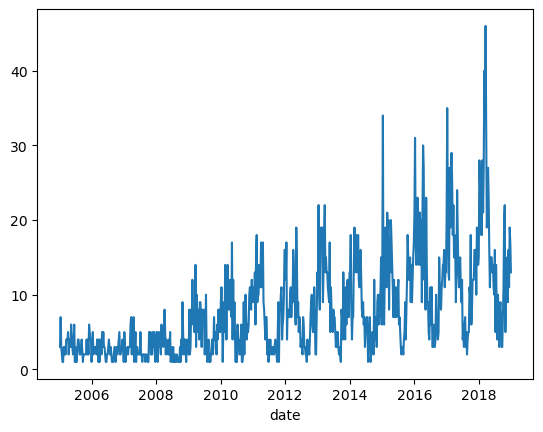

In [7]:
df[(df.location == 'DE') & (df.age_group == '00+')].set_index('date')['value'].plot()